In [17]:
#importing all libraries and getting set up 
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import keras
import keras.backend as K
from keras.datasets import mnist
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import *
from keras.utils.generic_utils import Progbar
import tensorflow as tf
K.set_image_dim_ordering('th')




(20000, 4000)


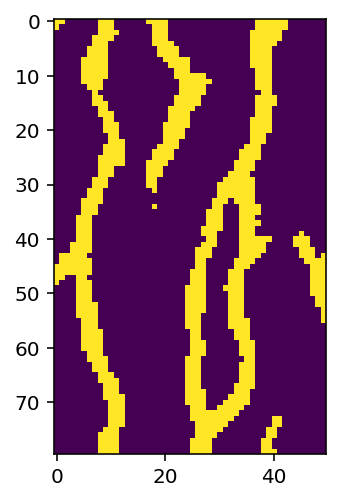

In [18]:
#Now importing and preprocessing of data
tr_im = np.loadtxt("reals.dat")
print (tr_im.shape)
nrow,ncol = 80,50
plt.imshow(tr_im[0,:].reshape(nrow,ncol))

In [19]:
#Setting up the loss fucntion and other variables needed to compile the final model

#This will ensure that the random seed we start with is identical everytime so that the our results are repeateable
RND = 777
np.random.seed(RND)

#number of standard normal deviates to feed to generator input
npar = 100

#defining the loss function
def d_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

#Setting our optimizer to make things flow easier later
opt = RMSprop(lr=0.0005)

In [23]:
#creating and compiling the discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding='same', input_shape=(1, 80, 50), kernel_initializer=initializers.RandomNormal(mean=0.5,stddev=0.002)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(128, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.35))
discriminator.add(Conv2D(256, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(512, kernel_size=5, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Flatten())
output_is_fake = discriminator.add(Dense(1, activation='linear'))
discriminator.compile(loss=d_loss, optimizer=opt)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 64, 40, 25)        640       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 64, 40, 25)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 64, 40, 25)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 20, 13)       204928    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 128, 20, 13)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 128, 20, 13)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 256, 10, 7)        819456    
__________

In [24]:
#creating the generator but not yet compiling it
generator = Sequential()
generator.add(Dense(npar*8*5, input_shape=(npar,), kernel_initializer=initializers.RandomNormal(stddev=0.002)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((npar, 8, 5)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(256, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(128, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(5, 5)))
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 4000)              404000    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 4000)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 100, 8, 5)         0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 100, 16, 10)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 16, 10)       640256    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 256, 16, 10)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 16, 10)       819328    
__________

In [25]:
#Now we build and compile the final model

#defining the generator input
gi = keras.layers.Input(shape=(npar,))

#Creating the combined model
output_is_fake = discriminator(generator(inputs=gi))
WGAN = Model(inputs=gi, outputs='dense_1')

DG.compile(
    optimizer=RMSprop(lr=0.00005),
    loss=d_loss
)

ValueError: Output tensors to a Model must be the output of a Keras `Layer` (thus holding past layer metadata). Found: dense_1